## Use Pretrained ResNet50 for Feature Extraction of SVI

In [ ]:
# import
import os
import time
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Initialize device (use GPU if available, otherwise fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-50 model for feature extraction
model = models.resnet50(weights=ResNet50_Weights.DEFAULT) 
model.fc = torch.nn.Identity()  # Replace the fully connected layer with an identity mapping to extract features
model = model.to(device)
model.eval()  # Set model to evaluation mode

# Define preprocessing steps for input images
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])


# Function to extract features from an image
def extract_features(image_path, model, preprocess, device):
    """
    Extracts feature vectors from a given image using a pre-trained model.
    
    Parameters:
    - image_path (str): Path to the input image.
    - model: Pre-trained PyTorch model used for feature extraction.
    - preprocess: Transformation pipeline applied to the image before inference.
    - device: The device (CPU or GPU) on which the model is running.
    
    Returns:
    - np.ndarray: Extracted feature vector, or None if an error occurs.
    """
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(device)
        
        # Perform inference without tracking gradients
        with torch.no_grad():
            features = model(input_tensor)
        
        return features.cpu().numpy().flatten()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None  # Return None if extraction fails


## Pre-feature extraction estimations 

This project contains many computationally and time-intensive processes. There is only so much optimization for space and time that can be performed. However, in order to properly plan for each part of this process, a new implementation of the spring semester has been to include estimations for both space and time *before* running all code. Doing such estimations helps to avoid hitting data limits, and to plan out times to have my personal computer running. In the following sections, I estimate the processing time to perform feature extraction for ~105 census tracts. 

Estimating processing time for segmented images...
Extracted features saved to Segmented Images_features.npy


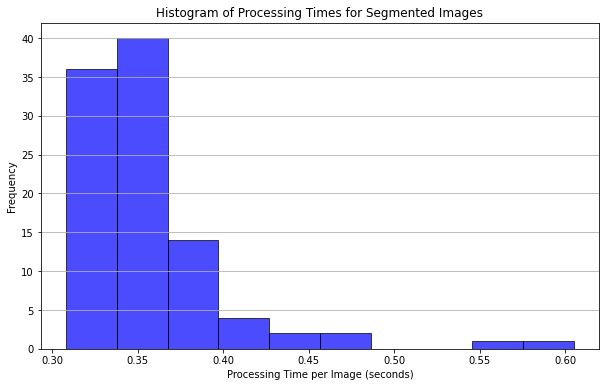

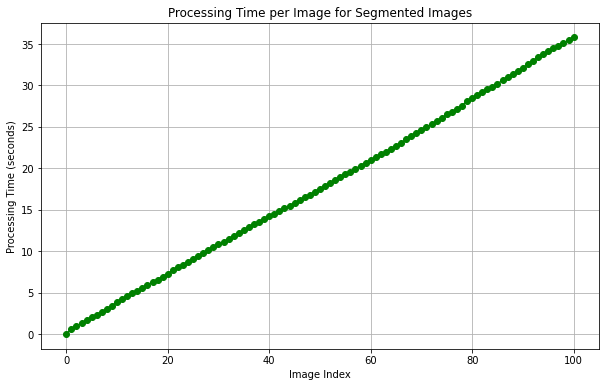

Dataset: Segmented Images
Total Images: 100
Average Time Per Image: 0.3579 seconds
Estimated Total Time: 0.60 minutes



(100, 0.35789439916610716, 35.78943991661072)

In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

def estimate_processing_time_and_visualize(root_dir, model, preprocess, device, dataset_name, max_samples=100):
    """
    Estimates the processing time for extracting features from images in a given directory and visualizes results.
    
    Parameters:
    - root_dir (str): Path to the directory containing images.
    - model: Pre-trained model used for feature extraction.
    - preprocess: Preprocessing function for input images.
    - device: Device (CPU/GPU) to run the model on.
    - dataset_name (str): Name of the dataset (used for visualization titles and file naming).
    - max_samples (int, optional): Maximum number of images to process. Default is 100.
    
    Returns:
    - total_images (int): Total number of images found in the directory.
    - avg_time_per_image (float): Average processing time per image.
    - estimated_total_time (float): Estimated total time for processing the entire dataset.
    """
    total_images = 0  # Counter for total images in the directory
    processing_times = []  # List to store processing time per image
    total_processing_times = [0]  # Cumulative processing time
    feature_storage = {}  # Dictionary to store extracted features

    # Walk through the directory structure to find image files
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
                total_images += 1
                image_path = os.path.join(subdir, file)

                # Measure time taken to extract features for a single image
                start_time = time.time()
                features = extract_features(image_path, model, preprocess, device)
                elapsed_time = time.time() - start_time  # Compute elapsed time
                
                processing_times.append(elapsed_time)  # Store individual processing time
                total_processing_times.append(np.sum(processing_times))  # Store cumulative processing time
                
                # Store extracted features in dictionary
                feature_storage[image_path] = features

                # Stop processing after reaching max_samples limit
                if len(processing_times) >= max_samples:
                    break
        if len(processing_times) >= max_samples:
            break

    # Save extracted features as a NumPy binary file
    features_output_path = f"{dataset_name}_features.npy"
    np.save(features_output_path, feature_storage)
    print(f"Extracted features saved to {features_output_path}")

    # Plot histogram of processing times per image
    plt.figure(figsize=(10, 6))
    plt.hist(processing_times, bins=10, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Histogram of Processing Times for {dataset_name}")
    plt.xlabel("Processing Time per Image (seconds)")
    plt.ylabel("Frequency")
    plt.grid(axis='y')
    plt.show()

    # Plot cumulative processing time as a line graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(total_processing_times)), total_processing_times, marker='o', linestyle='-', color='green')
    plt.title(f"Processing Time per Image for {dataset_name}")
    plt.xlabel("Image Index")
    plt.ylabel("Processing Time (seconds)")
    plt.grid()
    plt.show()

    # Compute statistics
    avg_time_per_image = np.mean(processing_times)  # Mean processing time per image
    estimated_total_time = avg_time_per_image * total_images  # Estimate total processing time for full dataset

    # Print summary statistics
    print(f"Dataset: {dataset_name}")
    print(f"Total Images: {total_images}")
    print(f"Average Time Per Image: {avg_time_per_image:.4f} seconds")
    print(f"Estimated Total Time: {estimated_total_time / 60:.2f} minutes\n")

    return total_images, avg_time_per_image, estimated_total_time

# Define the directory containing segmented images
segmented_dir = "/Volumes/MRDALLMAYR/data/img_mapillary_images_osm_full"

# Run processing time estimation and visualization for segmented images
echo "Estimating processing time for segmented images..."
estimate_processing_time_and_visualize(segmented_dir, model, preprocess, device, "Segmented Images", max_samples=100)


In [4]:
# EST TIME for all census tracts (only sampling for 100) 
n_images = 500 * 100  # 500 images * ~ 100 CT 
est_min = (0.3579 * n_images ) / 60 
est_hours = est_min / 60 
print("Estimated Min:", est_min, "Est Hours:", est_hours)

Estimated Min: 298.25 Est Hours: 4.970833333333333


In [7]:
# EST STORAGE for all image from census tracts (only sampling for 100) 
for_100_imgs = 835 # KB 
per_1 = for_100_imgs / 100
for_all = n_images * per_1
print(for_all, "kB", for_all/1e6, "gB")

417500.0 kB 0.4175 gB


In [20]:
import os
import time
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision.models import ResNet50_Weights

# Function to save extracted features for all images in each folder
def save_features_by_folder(root_dir, model, preprocess, device, output_base_dir):
    """
    Extracts and saves features for all images within subdirectories of a given root directory.
    
    Parameters:
    - root_dir (str): Path to the root directory containing image folders.
    - model: Pre-trained PyTorch model used for feature extraction.
    - preprocess: Image transformation pipeline.
    - device: The device (CPU or GPU) to use for inference.
    - output_base_dir (str): Directory where extracted feature files will be saved.
    """
    for subdir, _, files in os.walk(root_dir):
        folder_name = os.path.basename(subdir)
        output_path = os.path.join(output_base_dir, f"features_{folder_name}.npy")
        
        # Skip folder if features already saved
        if os.path.exists(output_path):
            print(f"Skipping folder {folder_name}, features already exist at {output_path}")
            continue

        feature_storage = {}

        # Extract features for each image
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(subdir, file)
                features = extract_features(image_path, model, preprocess, device)
                if features is not None:
                    feature_storage[image_path] = features

        # Save extracted features if available
        if feature_storage:
            np.save(output_path, feature_storage)
            print(f"Features for folder {folder_name} saved to {output_path}")
        else:
            print(f"No valid images found in folder {folder_name}.")

# Paths to input data and output directory
segmented_dir = "/Volumes/MRDALLMAYR/data/mapillary_osm_imgs_segmented"
output_dir = "/Users/etoileboots/Desktop/CAPSTONE/res_net/features_and_visualizations"
os.makedirs(output_dir, exist_ok=True)

# Extract features for all images and save results
print("Processing all folders and saving features...")
save_features_by_folder(segmented_dir, model, preprocess, device, output_dir)


Estimating processing time for 100 samples...
Average Time Per Image: 0.4701 seconds
Estimated Total Time for 100 images: 0.78 minutes
Processing all folders and saving features...
No valid images found in folder mapillary_osm_imgs_segmented.
Skipping folder 48201220500, features already saved at /Users/etoileboots/Desktop/CAPSTONE/res_net/features_and_visualizations/features_48201220500.npy
Skipping folder 48201312700, features already saved at /Users/etoileboots/Desktop/CAPSTONE/res_net/features_and_visualizations/features_48201312700.npy
Skipping folder 48201314401, features already saved at /Users/etoileboots/Desktop/CAPSTONE/res_net/features_and_visualizations/features_48201314401.npy
Skipping folder 48201450900, features already saved at /Users/etoileboots/Desktop/CAPSTONE/res_net/features_and_visualizations/features_48201450900.npy
Skipping folder 48201521202, features already saved at /Users/etoileboots/Desktop/CAPSTONE/res_net/features_and_visualizations/features_48201521202.n

## Compare feature extraction divergences and average behavior between sample sizes of 100, 200, 300, 400, and 500 images

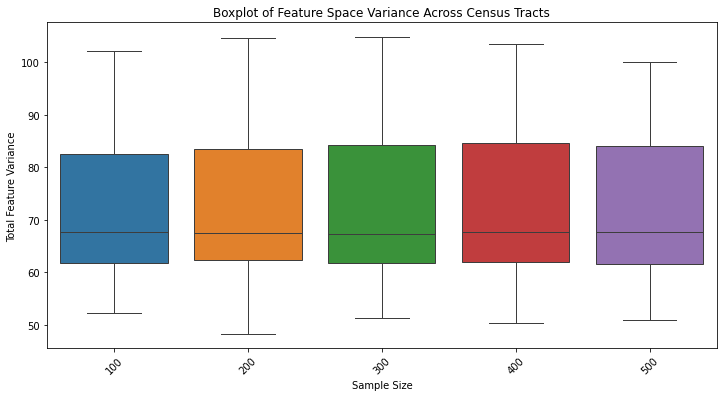

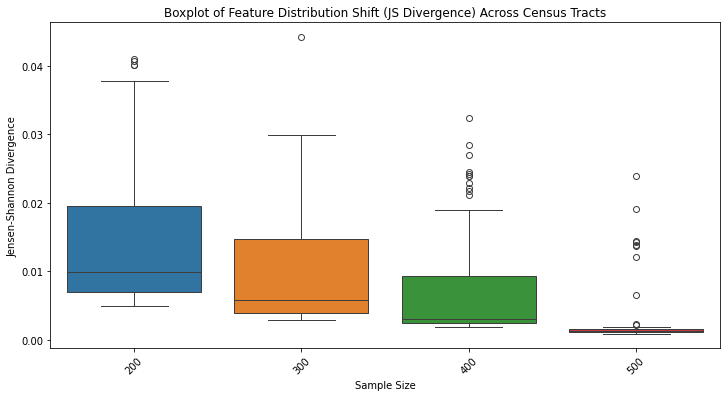

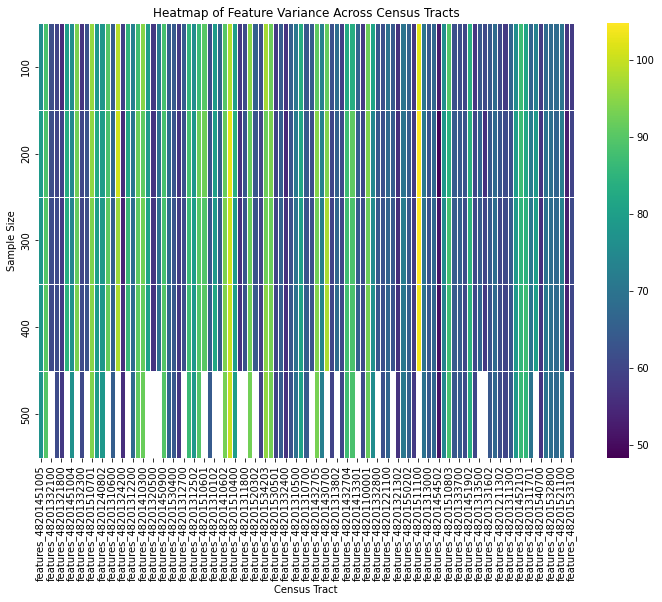

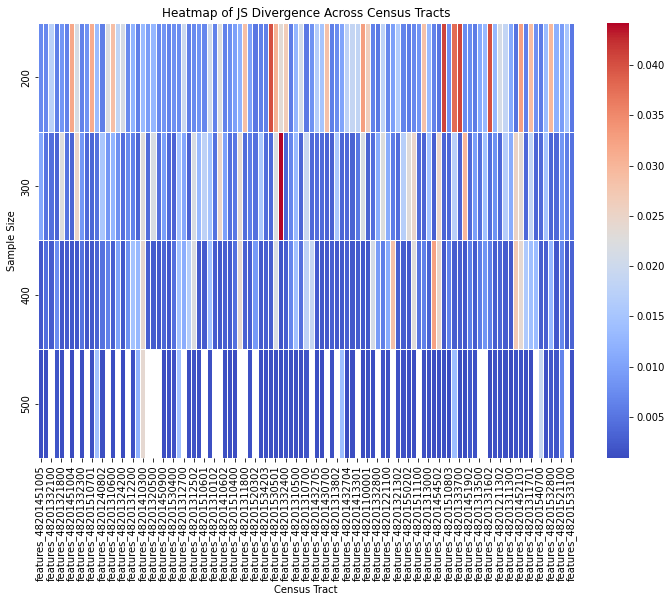

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial.distance import jensenshannon

# Define the folder containing the .npy files of extracted features 
folder_path = "/Users/etoileboots/Desktop/CAPSTONE/res_net/features_and_visualizations" 

# Get all .npy feature files
feature_files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]

# Dictionary to store results for each census tract
tract_results = {}

# Define sample sizes
sample_sizes = [100, 200, 300, 400, 500]

# Loop through each .npy file (each representing a different census tract)
for file in feature_files:
    tract_name = file.replace(".npy", "")  # Extract tract identifier
    file_path = os.path.join(folder_path, file)

    # Load features
    features_dict = np.load(file_path, allow_pickle=True).item()
    feature_vectors = np.array(list(features_dict.values()))  # 2048D feature vectors

    # Check available images and adjust sample sizes if necessary
    max_size = min(500, feature_vectors.shape[0])
    valid_sample_sizes = [s for s in sample_sizes if s <= max_size]

    # Store results for this tract
    tract_results[tract_name] = {"variance": {}, "js_divergence": {}}

    prev_distribution = None

    for size in valid_sample_sizes:
        # Sample `size` images randomly
        sampled_indices = np.random.choice(range(feature_vectors.shape[0]), size, replace=False)
        sampled_features = feature_vectors[sampled_indices]

        # Compute total variance across all 2048 feature dimensions
        total_variance = np.var(sampled_features, axis=0).sum()
        tract_results[tract_name]["variance"][size] = total_variance

        # Compute JS divergence with the previous sample size distribution
        if prev_distribution is not None:
            # Normalize feature distributions
            prev_hist, _ = np.histogram(prev_distribution.flatten(), bins=50, density=True)
            curr_hist, _ = np.histogram(sampled_features.flatten(), bins=50, density=True)
            js_div = jensenshannon(prev_hist, curr_hist)
            tract_results[tract_name]["js_divergence"][size] = js_div

        prev_distribution = sampled_features

# Convert results to DataFrames for comparison
variance_df = pd.DataFrame({tract: tract_results[tract]["variance"] for tract in tract_results})
js_divergence_df = pd.DataFrame({tract: tract_results[tract]["js_divergence"] for tract in tract_results})

# Create boxplot for variance across sample sizes
plt.figure(figsize=(12, 6))
sns.boxplot(data=variance_df.T)  # Transpose so sample sizes are on x-axis
plt.xlabel("Sample Size")
plt.ylabel("Total Feature Variance")
plt.title("Feature Space Variance Across Census Tracts")
plt.xticks(rotation=45)
plt.show()

# Create boxplot for JS divergence across sample sizes
plt.figure(figsize=(12, 6))
sns.boxplot(data=js_divergence_df.T)  # Transpose so sample sizes are on x-axis
plt.xlabel("Sample Size")
plt.ylabel("Jensen-Shannon Divergence")
plt.title("Feature Distribution Shift (JS Divergence) Across Census Tracts")
plt.xticks(rotation=45)
plt.show()

# Create heatmap for variance trends
plt.figure(figsize=(12, 8))
sns.heatmap(variance_df, cmap="viridis", annot=False, linewidths=0.5)
plt.xlabel("Census Tract")
plt.ylabel("Sample Size")
plt.title("Heatmap of Feature Variance Across Census Tracts")
plt.show()

# Create heatmap for JS divergence trends
plt.figure(figsize=(12, 8))
sns.heatmap(js_divergence_df, cmap="coolwarm", annot=False, linewidths=0.5)
plt.xlabel("Census Tract")
plt.ylabel("Sample Size")
plt.title("Heatmap of JS Divergence Across Census Tracts")
plt.show()


In [23]:
# Convert results to DataFrames for comparison
variance_df = pd.DataFrame({tract: tract_results[tract]["variance"] for tract in tract_results})
js_divergence_df = pd.DataFrame({tract: tract_results[tract]["js_divergence"] for tract in tract_results})

# Compute confidence intervals for variance and JS divergence
variance_mean = variance_df.mean(axis=1)
variance_std = variance_df.std(axis=1)
js_div_mean = js_divergence_df.mean(axis=1)
js_div_std = js_divergence_df.std(axis=1)

print("Variance DataFrame:")
print(variance_df)
print("\nVariance Mean and Std:")
print(pd.DataFrame({'Mean': variance_mean, 'Std': variance_std}))

print("\nJensen-Shannon Divergence DataFrame:")
print(js_divergence_df)
print("\nJS Divergence Mean and Std:")
print(pd.DataFrame({'Mean': js_div_mean, 'Std': js_div_std}))

Variance DataFrame:
     features_48201451005  features_48201410703  features_48201332100  \
100             75.488152             88.352364             61.737564   
200             79.109535             88.578217             61.637150   
300             77.851212             89.385818             61.533691   
400             77.570702             90.141106             60.957275   
500             77.034203             89.779465                   NaN   

     features_48201211900  features_48201321800  features_48201510702  \
100             59.969650             55.048714             79.459839   
200             60.091991             59.511604             83.381943   
300             61.327808             57.938347             83.391174   
400             61.527061             57.628181             84.503876   
500             61.294647             57.641014                   NaN   

     features_48201451004  features_48201530200  features_48201332300  \
100             76.318031    

## PCA Analysis

Explained Variance Ratio: [1.50917247e-01 7.53765851e-02 5.44983819e-02 4.29771394e-02
 2.66802218e-02 2.29709428e-02 2.23582722e-02 2.12624054e-02
 2.06477437e-02 1.94066446e-02 1.61153655e-02 1.29543468e-02
 1.17216883e-02 1.11911595e-02 1.05971312e-02 9.80106182e-03
 9.12884902e-03 8.32249969e-03 8.29396676e-03 7.94079900e-03
 7.59852072e-03 7.46654347e-03 6.96994364e-03 6.48034178e-03
 6.06499845e-03 5.85908256e-03 5.50697651e-03 5.39821107e-03
 5.22578368e-03 4.99674678e-03 4.91457433e-03 4.54553589e-03
 4.48937342e-03 4.32489766e-03 4.19385172e-03 4.05911077e-03
 3.93552706e-03 3.92512279e-03 3.74680222e-03 3.63796018e-03
 3.44573450e-03 3.33559513e-03 3.26668960e-03 3.14448774e-03
 3.04352795e-03 3.03115649e-03 2.90051079e-03 2.85589625e-03
 2.78850412e-03 2.75360490e-03 2.70818127e-03 2.63099000e-03
 2.57294159e-03 2.54403241e-03 2.47623329e-03 2.41367612e-03
 2.38514529e-03 2.31405091e-03 2.28098338e-03 2.20176461e-03
 2.15864484e-03 2.13281927e-03 2.09951540e-03 2.06161593e-0

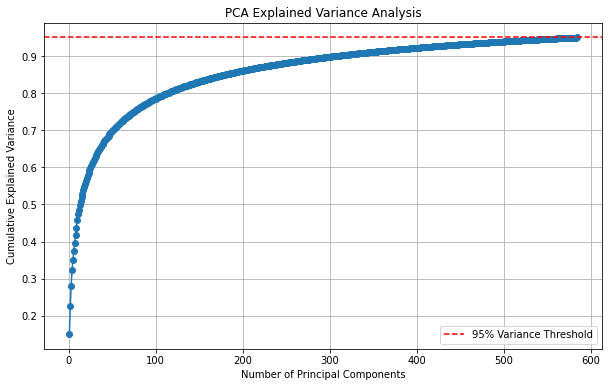

Number of Principal Components needed to retain 95% variance: 584


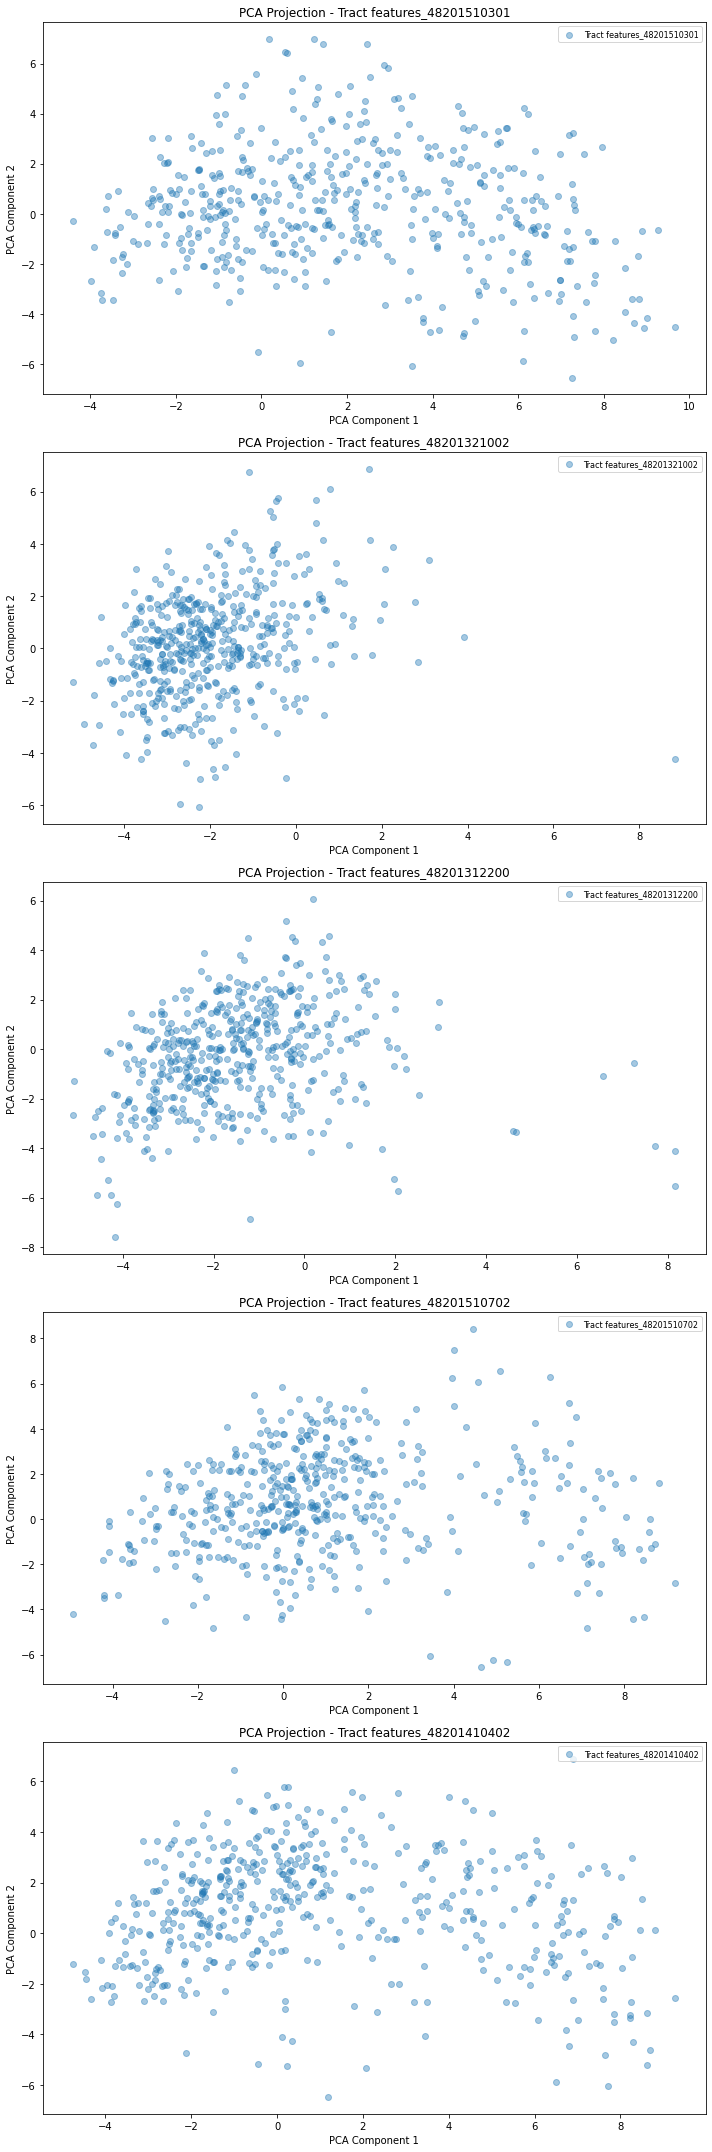

In [35]:

# Get all .npy feature files
folder_path = "/Users/etoileboots/Desktop/CAPSTONE/res_net/features_and_visualizations" 

feature_files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]

# Dictionary to store feature vectors for each census tract
tract_features = {}

# Load feature vectors from each .npy file
for file in feature_files:
    tract_name = file.replace(".npy", "")  # Extract tract identifier
    file_path = os.path.join(folder_path, file)
    features_dict = np.load(file_path, allow_pickle=True).item()
    tract_features[tract_name] = np.array(list(features_dict.values()))  # Convert to NumPy array

# Combine all feature vectors across tracts for PCA
all_features = np.vstack(list(tract_features.values()))

# Apply PCA across all tracts
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% variance
pca.fit(all_features)

# Transform each tract using the same PCA model and store labeled components
tract_pca_results = {}
for tract in tract_features:
    transformed_features = pca.transform(tract_features[tract])
    tract_pca_results[tract] = {f"PCA_{i+1}": transformed_features[:, i] for i in range(transformed_features.shape[1])}

# Print PCA explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Plot cumulative explained variance to visualize how many components are needed for 95%
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Analysis")
plt.legend()
plt.grid()
plt.show()

# Print the number of components needed to reach 95% variance
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of Principal Components needed to retain 95% variance: {num_components_95}")

# Randomly select 5 tracts to display PCA scatter plots
selected_tracts = random.sample(list(tract_pca_results.keys()), min(5, len(tract_pca_results)))

# Create subplots for selected tracts
fig, axes = plt.subplots(len(selected_tracts), 1, figsize=(10, 6 * len(selected_tracts)))
if len(selected_tracts) == 1:
    axes = [axes]  # Ensure iterable if only one subplot

for ax, tract in zip(axes, selected_tracts):
    ax.scatter(tract_pca_results[tract]["PCA_1"], tract_pca_results[tract]["PCA_2"], alpha=0.4, label=f"Tract {tract}")
    ax.set_title(f"PCA Projection - Tract {tract}")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.legend(loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()


# Training the model - basic linear regression


In [74]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -------------------------
# 1️⃣ Load PCA-Transformed Features
# -------------------------
folder_path = "/Users/etoileboots/Desktop/CAPSTONE/res_net/features_and_visualizations"  # Update if necessary
feature_files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]

tract_features = {}

for file in feature_files:
    tract_name = file.replace(".npy", "")  # Extract tract identifier
    file_path = os.path.join(folder_path, file)
    features_dict = np.load(file_path, allow_pickle=True).item()
    tract_features[tract_name] = np.array(list(features_dict.values()))  # Convert to NumPy array

# Combine all feature vectors for PCA
all_features = np.vstack(list(tract_features.values()))

# Apply PCA - Keep enough components to explain 95% variance
pca = PCA(n_components=0.95)
pca.fit(all_features)

# -------------------------
# 2️⃣ Transform and Store Tract-Level PCA Features
# -------------------------
tract_pca_results = {}

for tract in tract_features:
    transformed_features = pca.transform(tract_features[tract])
    tract_pca_results[tract] = transformed_features.mean(axis=0)  # Use mean PCA features per tract

# Convert to DataFrame
pca_df = pd.DataFrame.from_dict(tract_pca_results, orient="index")

# Ensure correct column naming
pca_df.columns = [f"PCA_{i+1}" for i in range(pca_df.shape[1])]

# Convert index to a proper column for merging
pca_df.index.name = "GEOID20"
pca_df.reset_index(inplace=True)

# Print Results
print("PCA-transformed feature DataFrame shape:", pca_df.shape)
print(pca_df.head())

PCA-transformed feature DataFrame shape: (105, 585)
                GEOID20     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5  \
0  features_48201451005  6.933016 -1.178870  0.411211  1.243453 -0.690079   
1  features_48201410703  0.713550  0.336753  0.208136  1.711153  0.366040   
2  features_48201332100 -2.695693 -0.181248  0.489524  0.963960 -0.610381   
3  features_48201211900 -2.468397  0.036428  0.635333  0.813638 -0.289259   
4  features_48201321800 -2.920471 -0.121099  1.017982  0.689486 -0.475308   

      PCA_6     PCA_7     PCA_8     PCA_9  ...   PCA_575   PCA_576   PCA_577  \
0 -0.227185  0.234747 -0.059961  0.740345  ...  0.010545 -0.009817 -0.014065   
1  0.187640 -0.271740 -0.359627  0.654526  ... -0.015969  0.007023 -0.014365   
2 -0.125726 -0.566191  0.205064  0.233138  ... -0.002387 -0.008881 -0.009274   
3 -0.340211  0.905571  0.564092  0.624679  ... -0.000554  0.001270 -0.017447   
4  0.389264 -0.145905  0.413126  0.423593  ... -0.006513 -0.000616  0.002533   

    

In [75]:
# rename the geiod data frame 
pca_df.index = pca_df.index.astype(str)  # Ensure index is string type
pca_df["GEOID20"] = pca_df["GEOID20"].astype(str).str.replace("features_", "", regex=False)
pca_df.head()

,GEOID20,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_575,PCA_576,PCA_577,PCA_578,PCA_579,PCA_580,PCA_581,PCA_582,PCA_583,PCA_584
0,48201451005,6.933016,-1.178870,0.411211,1.243453,-0.690079,-0.227185,0.234747,-0.059961,0.740345,...,0.010545,-0.009817,-0.014065,0.001605,-0.015541,0.003934,-0.001759,0.023466,-0.001882,-0.004205
1,48201410703,0.713550,0.336753,0.208136,1.711153,0.366040,0.187640,-0.271740,-0.359627,0.654526,...,-0.015969,0.007023,-0.014365,-0.008038,0.007496,0.001980,-0.008214,-0.002246,-0.000548,0.000816
2,48201332100,-2.695693,-0.181248,0.489524,0.963960,-0.610381,-0.125726,-0.566191,0.205064,0.233138,...,-0.002387,-0.008881,-0.009274,0.001128,-0.003877,0.006001,0.006282,-0.005506,-0.007287,0.002639
3,48201211900,-2.468397,0.036428,0.635333,0.813638,-0.289259,-0.340211,0.905571,0.564092,0.624679,...,-0.000554,0.001270,-0.017447,0.003815,-0.002132,-0.007408,0.000198,0.007718,-0.007893,0.001637
4,48201321800,-2.920471,-0.121099,1.017982,0.689486,-0.475308,0.389264,-0.145905,0.413126,0.423593,...,-0.006513,-0.000616,0.002533,-0.009773,0.002294,-0.006900,-0.003710,0.003352,0.000606,0.003489


In [76]:
# SOCIODEMOGRAPHICS
# -------------------------
# 2️⃣ Load Sociodemographic Data
# -------------------------
csv_path = "/Volumes/MRDALLMAYR/data/census_data/census_data_harris_county_2022.csv"  # Update if necessary
socio_df = pd.read_csv(csv_path, dtype={"GEOID20": str})  # Load as string to avoid type mismatches

# Select relevant columns (remove categorical or ID columns)
target_columns = [
    "median_income", "pct_income_below_poverty", "pct_income_above_poverty", 
    "pct_no_vehicle", "pct_public_transport", "pct_commute_more_than_60"
]

socio_df = socio_df[["GEOID20"] + target_columns]  # Keep only relevant data
socio_df.head()

,GEOID20,median_income,pct_income_below_poverty,pct_income_above_poverty,pct_no_vehicle,pct_public_transport,pct_commute_more_than_60
0,48201100001,84213.0,15.502825,84.497175,11.012542,2.018966,0.195542
1,48201210400,51964.0,21.742405,78.257595,7.478525,10.763012,7.207207
2,48201210500,44792.0,23.209719,76.790281,8.078141,4.435058,4.709302
3,48201210600,83257.0,4.208899,95.791101,8.131488,1.868512,3.654224
4,48201210700,49588.0,19.429025,80.570975,1.986183,5.593804,7.069767
